In [9]:
# import Beautiful Soup, NumPy and Pandas, etc
import bs4 as bs
import numpy as np
import pandas as pd
import re
import hashlib
import glob

 
# download NLTK classifiers - these are cached locally on your machine
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

# import ml classifiers
from nltk.tokenize import sent_tokenize # tokenizes sentences
from nltk.stem import PorterStemmer     # parsing/stemmer
from nltk.tag import pos_tag            # parts-of-speech tagging
from nltk.corpus import wordnet         # sentiment scores
from nltk.stem import WordNetLemmatizer # stem and context
from nltk.corpus import stopwords       # stopwords
from nltk.util import ngrams            # ngram iterator

# import word2vec
from gensim.test.utils import datapath
from gensim import utils
from gensim.models import Word2Vec

# import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer

# imbalance learning
from imblearn.metrics import classification_report_imbalanced,geometric_mean_score
from imblearn.over_sampling import SMOTE

# data visualization library  
import seaborn as sns 
import matplotlib.pyplot as plt

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sixumeng/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sixumeng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sixumeng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sixumeng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Part I: Data Loading and Preprocessing

In [10]:
def conditions(s):
    if (s["Rating"] >=4):return 1
    elif (s["Rating"] <=2):return 0
    else:return -1

In [11]:
volvo_df = pd.read_csv("data/Volvo_edmunds_10yrs.csv",lineterminator='\n').iloc[:,1:]
volvo_df["Rating"] = volvo_df["Customer_Rating"]
volvo_df["sentiment"] = volvo_df.apply(conditions, axis=1)
volvo_df =volvo_df[volvo_df['sentiment']!=-1]
volvo_df = volvo_df[["sentiment","Review"]].replace(' ',np.nan).dropna()

In [12]:
other_df = pd.read_csv("data/other_car_review_volvo.csv")[["Review","Rating"]].replace(' .',np.nan).replace(' ',np.nan).dropna()
other_df["sentiment"] = other_df.apply(conditions, axis=1)
other_df =other_df[other_df['sentiment']!=-1]
other_df = other_df[["sentiment","Review"]]

In [13]:
train = pd.concat([volvo_df,other_df]).reset_index()

/Users/sixumeng/opt/anaconda3/envs/VSMS/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


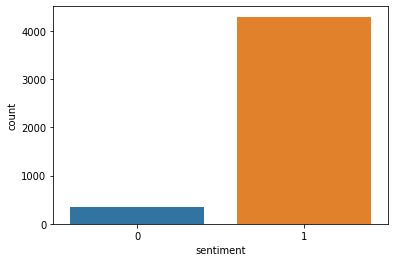

In [14]:
ax = sns.countplot(train['sentiment'],label="Count")

<br>

___


## Preparing data for classification



We have provided the function `review_cleaner` to preprocess reviews. Here is an overview of what it does:

> - Removes HTML tags (using beautifulsoup)
> - Extract emoticons (emotion symbols, aka smileys :D )
> - Removes non-letters (using regular expression)
> - Converts all words to lowercase letters and tokenizes them (using .split() method on the review strings, so that every word in the review is an element in a list)
> - Removes all the English stopwords from the list of movie review words
> - Applies either stemming or lemmatization, as indicated by the arguments
> - Join the words back into one string seperated by space, append the emoticons to the end

Note that you do not need to make any changes to `review_cleaner`. We will explore some examples of the cleaning process below.

<br>


In [15]:
ps = PorterStemmer()
wnl = WordNetLemmatizer()
eng_stopwords = set(stopwords.words("english"))

def review_cleaner(review, lemmatize=True, stem=False):
    '''
        Clean and preprocess a review.
            1. Remove HTML tags
            2. Extract emoticons
            3. Use regex to remove all special characters (only keep letters)
            4. Make strings to lower case and tokenize / word split reviews
            5. Remove English stopwords
            6. Lemmatize
            7. Rejoin to one string
        
        @review (type:str) is an unprocessed review string
        @return (type:str) is a 6-step preprocessed review string
    '''

    if lemmatize == True and stem == True:
        raise RuntimeError("May not pass both lemmatize and stem flags")

    #1. Remove HTML tags
    review = bs.BeautifulSoup(review).text    

    #2. Use regex to find emoticons
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', review)

    #3. Remove punctuation
    review = re.sub("[^a-zA-Z]", " ",review)

    #4. Tokenize into words (all lower case)
    review = review.lower().split()

    #5. Remove stopwords, Lemmatize, Stem
    clean_review=[]
    for word in review:
        if word not in eng_stopwords:
            if lemmatize is True:
                word=wnl.lemmatize(word)
            elif stem is True:
                if word == 'oed':
                    continue
                word=ps.stem(word)
            clean_review.append(word)

    #6. Join the review to one sentence
    review_processed = ' '.join(clean_review+emoticons)
    
    return review_processed

# Explore text cleaning

In [95]:
# Your code here
seed_value = 52

In [96]:
# We vectorize the text using a bag of words model

def get_vectorizer(ngram, max_features):
    return CountVectorizer(ngram_range=(1, ngram),
                             analyzer = "word",
                             tokenizer = None,
                             preprocessor = review_cleaner,
                             stop_words = None, 
                             max_features = max_features)

# Model training
def train_predict_sentiment(reviews, vectorizer, y=train["sentiment"], ngram=1, max_features=1000, model_random_state=123):
    '''
        This function will:
            1. split data into train and test set.
            2. get n-gram counts from cleaned reviews 
            3. train a random forest model using train n-gram counts and y (labels)
            4. test the model on your test split
            5. print accuracy of sentiment prediction on test and training data
            6. print confusion matrix on test data results

            To change n-gram type, set value of ngram argument
            To change the number of features you want the countvectorizer to generate, set the value of max_features argument
            
            @cleaned_review (type:str) is preprocessed string from review_cleaner()
            @return none
    '''
    
    # train / test split
    X_train, X_test, y_train, y_test = train_test_split(reviews, y, random_state=42, test_size=.3)

    # Then we use fit_transform() to fit the model / learn the vocabulary,
    # then transform the data into feature vectors.
    # The input should be a list of strings. .toarray() converts to a numpy array
    
    train_bag = vectorizer.fit_transform(X_train)
    if not isinstance(train_bag, np.ndarray):
        train_bag = train_bag.toarray()
    test_bag = vectorizer.transform(X_test)
    if not isinstance(test_bag, np.ndarray):
        test_bag = test_bag.toarray()
    
    smote = SMOTE(random_state = 101)
    train_bag, y_train = smote.fit_resample(train_bag, y_train)

    # Initialize a Random Forest classifier with 50 trees
    forest = RandomForestClassifier(n_estimators = 100, random_state = model_random_state) 

    # Fit the forest to the training set, using the bag of words as 
    # features and the sentiment labels as the target variable
    forest = forest.fit(train_bag, y_train)

    # predict
    train_predictions = forest.predict(train_bag)
    test_predictions = forest.predict(test_bag)
    
    # validation
    train_acc = metrics.accuracy_score(y_train, train_predictions)
    valid_acc = metrics.accuracy_score(y_test, test_predictions)
    
    print(" The training accuracy is: ", train_acc, "\n", "The validation accuracy is: ", valid_acc)
    print()
    c=confusion_matrix(y_test, test_predictions)
    
    print(classification_report_imbalanced(y_test, test_predictions))
        
    sns.heatmap(pd.DataFrame(c), annot=True, cmap="YlGnBu", fmt='g')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    

    return forest,train_bag,y_train

# Print out the top features
def top_features(forest, vectorizer, n):
    #Extract feature importance
    print('\nTOP TEN IMPORTANT FEATURES:')
    feature_text = vectorizer.get_feature_names().copy()
    feature_importance = forest.feature_importances_.copy()
    
    indices = np.argsort(feature_importance)[::-1]
    
    top_n_ind = indices[:n]
    top_n = list([vectorizer.get_feature_names()[ind] for ind in top_n_ind])
    
    print(top_n)

<br>

## Train Random Forest Classifier Model

 The training accuracy is:  0.9978318879252835 
 The validation accuracy is:  0.9375

                   pre       rec       spe        f1       geo       iba       sup

          0       0.55      0.60      0.96      0.57      0.76      0.55        97
          1       0.97      0.96      0.60      0.97      0.76      0.60      1295

avg / total       0.94      0.94      0.62      0.94      0.76      0.59      1392



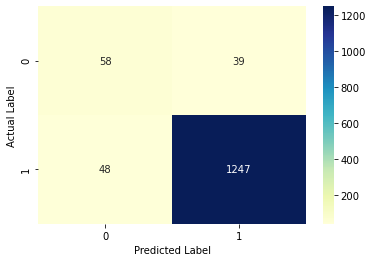

In [97]:
# Train RFC model
vectorizer = get_vectorizer(ngram=1, max_features=100)
forest_model,train_bag,y_train = train_predict_sentiment(reviews=train["Review"], vectorizer=vectorizer, y=train["sentiment"])

In [98]:
top_features(forest_model, vectorizer, 20)


TOP TEN IMPORTANT FEATURES:
['great', 'love', 'comfortable', 'car', 'drive', 'fun', 'best', 'interior', 'volvo', 'good', 'road', 'performance', 'ride', 'excellent', 'bmw', 'feel', 'time', 'well', 'turbo', 'wagon']


## Part III: Word2Vec Model

In [99]:
w2v_model = Word2Vec(sentences=[utils.simple_preprocess(review) for review in train['Review']], size=100, seed=123, workers=1)

In [100]:
def get_avg_feature_vecs(reviews, model):
    # Given a set of reviews (each one a list of words), calculate 
    # the average feature vector for each one 
    
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.wv.index2word)
    
    reviewFeatureVecs = []
    # Loop through the reviews
    for counter, review in enumerate(reviews):
        
        # Print a status message every 5000th review
        if (counter + 1) % 5000. == 0.:
            print("Review %d of %d" % (counter + 1, len(reviews)))

        # Function to average all of the word vectors in a given paragraph
        featureVec = []

        # Loop over each word in the review and, if it is in the model's
        # vocaublary, add its feature vector to the total
        for n,word in enumerate(utils.simple_preprocess(review)):
            if word in index2word_set: 
                featureVec.append(model.wv[word])

        # Average the word vectors for a 
        featureVec = np.mean(featureVec, axis=0).reshape(1,-1)

        reviewFeatureVecs.append(featureVec)

    return np.concatenate(reviewFeatureVecs, axis=0)

w2v_vectorizer = FunctionTransformer(lambda x: get_avg_feature_vecs(x, w2v_model))

 The training accuracy is:  1.0 
 The validation accuracy is:  0.9432471264367817

                   pre       rec       spe        f1       geo       iba       sup

          0       0.57      0.73      0.96      0.64      0.84      0.69        97
          1       0.98      0.96      0.73      0.97      0.84      0.72      1295

avg / total       0.95      0.94      0.75      0.95      0.84      0.72      1392



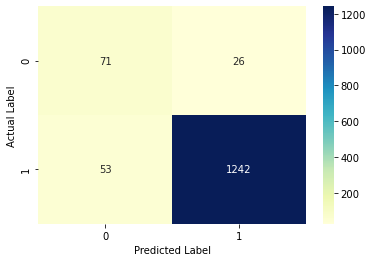

In [101]:
v2v_forest_model = train_predict_sentiment(reviews=train["Review"], vectorizer=w2v_vectorizer, y=train["sentiment"])

In [102]:
path = r'extra_data/' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, lineterminator='\r',error_bad_lines=False)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

In [103]:
other_source = frame["Review"].replace('NaN',np.nan).replace(' .',np.nan).replace(' ',np.nan).dropna()

In [104]:
# 1/ updating the vocabulary
newTrain = train['Review'].append(other_source)
# 2/ training the model
w2v_model = Word2Vec(sentences=[utils.simple_preprocess(review) for review in newTrain], size=100, seed=123, workers=1)

 The training accuracy is:  1.0 
 The validation accuracy is:  0.9568965517241379

                   pre       rec       spe        f1       geo       iba       sup

          0       0.67      0.74      0.97      0.71      0.85      0.71        97
          1       0.98      0.97      0.74      0.98      0.85      0.74      1295

avg / total       0.96      0.96      0.76      0.96      0.85      0.74      1392



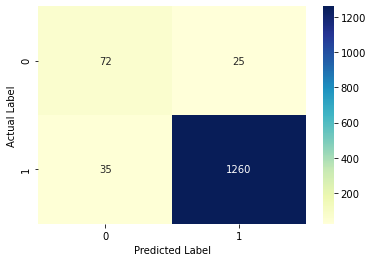

In [105]:
v2v_forest_model = train_predict_sentiment(reviews=train["Review"], vectorizer=w2v_vectorizer, y=train["sentiment"])